In [17]:
import numpy as np
import matplotlib.pyplot as plt
from beam_mechanics_3_script import simulate_beam, jacobian_tip_from_sim2, m_line_of_s
from constants import *
import types
from types import SimpleNamespace

Although this implmentation is quasi static, we define A and B matrices for implementation. 

In [2]:
def seq_mat(A, B, N):
    n, m = A.shape[0], B.shape[1]
    M = np.zeros((N*n,n))
    C = np.zeros((N*n, N*m))
    A_pow = np.eye(n)

    for i in range(1, N+1):
        A_pow = A@A_pow
        M[(i-1)*n:i*n,:] = A_pow
        
        for j in range(i):
            C[(i-1)*n: i*n, j*m:(j+1)*m] = np.linalg.matrix_power(A, i-1-j)@B
    return M,C 

Function for the block diagonal

In [3]:
def diag_bl(mat, times):
    r,c = mat.shape
    out = np.zeros((times*r, times*c))
    for i in range(times):
        out[i*r:(i+1)*r, i*c:(i+1)*c] = mat
    return out
    

Now build the mpc H and f matrices for quadratic programming

In [4]:
def mpc_setup(A, B, Q, R, B_th, Qf, N, xk, xref_seq=None):
    n, m = A.shape[0], B.shape[1]
    M, C = seq_mat(A,B,N)

    Qtil = diag_bl(Q, N-1)

    Qtil = np.block([
        [Qtil, np.zeros(((N-1)*n,n))],
        [np.zeros((n, (N-1)*n)), Qf]
    ])

    Rtil = diag_bl(R, N)
    if xref_seq is None:
        Rvec = np.zeros(N*n)
    else:
        Rvec = xref_seq.reshape(N*n)


    H = 2*(C.T@Qtil@C+Rtil)
    F = 2*  C.T@Qtil@(M@xk-Rvec)

    try:
        U_star = -np.linalg.solve(H,F)
    except np.linalg.LinAlgError:
        U_star = -np.linalg.lstsq(H,F, rcond=None)[0]
    X_pred = M@xk+C@U_star
    u0 = U_star[:m]
    E = np.linalg.solve(H, 2 * (C.T @ Qtil))          # shape: (N*m) x (N*n)
    L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
    lam_cl = 1.0 + float(B_th[0,0]) * L               # eigenvalue of A + B L (since A=1)
    print(f"L={L:+.6f},  lambda_cl={lam_cl:+.6f}")


    return u0, U_star, X_pred, H, F, M, C, Qtil

    


In [5]:
# def mpc_setup(A, B, Q, R, Qf, N, xk, xref_seq=None):
#     n, m = A.shape[0], B.shape[1]
#     M, C = seq_mat(A,B,N)

#     Qtil = diag_bl(Q, N-1)

#     Qtil = np.block([
#         [Qtil, np.zeros(((N-1)*n,n))],
#         [np.zeros((n, (N-1)*n)), Qf]
#     ])

#     Rtil = diag_bl(R, N)
#     if xref_seq is None:
#         Rvec = np.zeros(N*n)
#     else:
#         Rvec = xref_seq.reshape(N*n)


#     # exact predicted tracking (unconstrained, scalar integrator)
#     d = Rvec - (M @ xk)          # shape [N]
#     U_star = np.linalg.solve(C, d)  # since C = b*S is lower-triangular and invertible
#     X_pred = M @ xk + C @ U_star
#     u0 = U_star[:B.shape[1]]
#     H, F = None, None  # not used in this mode
#     return u0, U_star, X_pred, H, F, M, C, Qtil


    


The main MPC function will be implemented below. This function will be simple and provide a base MPC

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def print_rollout_table(k, t, dt, psi_k, u_star, S, theta_pred, R_vec):
    u_deg_s       = np.degrees(u_star)
    dpsi_deg      = np.degrees(S @ u_star)                 # cumulative Δψ
    psi_pred_deg  = np.degrees(psi_k + S @ u_star)
    theta_pred_deg= np.degrees(theta_pred)
    R_deg         = np.degrees(R_vec)
    err_deg       = theta_pred_deg - R_deg

    header = (f"\n[Rollout] k={k}  t={t:.3f}s  ψ_k={np.degrees(psi_k):+.2f}°  "
              f"max|Δψ|={np.max(np.abs(dpsi_deg)):.2f}°  max|θ̂-R|={np.max(np.abs(err_deg)):.2f}°")
    print(header)
    print(" i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]")
    print("-"*86)
    for i in range(len(u_star)):
        print(f"{i+1:2d} | {u_deg_s[i]:+12.2f} | {dpsi_deg[i]:+12.2f} |"
              f" {psi_pred_deg[i]:+11.2f} | {theta_pred_deg[i]:+11.2f} |"
              f" {R_deg[i]:+11.2f} | {err_deg[i]:+13.2f}")

In [7]:
def simple_mpc(ref, T, dt, p_vec, *, Np = 15, w_th=1.0, w_u=1e-3, psi0_rad=0.0, J_min=1e-5, s_steps=200):
    
    t_hist, th_hist, thref_hist, psi_hist, u_hist, J_hist = [], [], [], [], [], []
    pred_theta_hist_deg, pred_psi_hist_deg = [], []
    pred_ref_hist_deg,   pred_u_hist_deg_s = [], []
    e1_hist_deg = []
    psi = psi0_rad


    N = int(T/dt)
    for k in range(N):
        t = k*dt
        theta0, k_star, sol_ivp, info = simulate_beam(p_vec, np.rad2deg(psi), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val)
        sim = {"theta_tip": theta0, "sol_ivp": sol_ivp, "info": info}
        theta_tip, J0, pack = jacobian_tip_from_sim2(
            p_vec, psi,
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s, GRAD_SCALE=1.0, s_steps=400,
            sim=sim,              
        )

        R_vec = np.array([ref(t+(i+1)*dt)[0] for i in range(Np)],dtype=float)
        A_th = np.array([[1.0]])
        B_th = np.array([[J0*dt]])
        Q_th = np.array([[w_th]])
        R_u = np.array([[w_u]])
        Qf_th = Q_th

        xk_th = np.array([theta0])
        xref_seq = R_vec.reshape(Np,1)

        u0, U_star, X_pred, H, F, M, C, Qtil = mpc_setup(A_th, B_th, Q_th, R_u, B_th, Qf_th, Np, xk_th, xref_seq)
        # assert np.allclose(X_pred.reshape(Np), R_vec, atol=1e-10), "Predicted != reference"

        u_apply = float(u0)
        psi_next = psi + u_apply*dt

        theta_pred = X_pred.reshape(Np)
        theta_next,_,_,_ = simulate_beam(p_vec, np.rad2deg(psi_next), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val)
        e1_hist_deg.append(np.degrees(theta_next-theta_pred[0]))

        S = np.tril(np.ones((Np, Np), float)) * dt
        psi_pred = psi + S @ U_star.reshape(-1)
        print_rollout_table(k, t, dt, psi, U_star.reshape(-1), S, theta_pred, R_vec)
        # print(
        # # f"step={k} | J0={J0:.3e} | ||H||={np.linalg.norm(H):.3e} "
        # f"| ||F||={np.linalg.norm(F):.3e} | ||U*||={np.linalg.norm(U_star):.3e}"
        # )
        lam_min = np.linalg.eigvalsh(C.T @ Qtil @ C).min()
        rho = w_u / lam_min
        print(f"lam_min(C^T Q C)={lam_min:.2e}  rho={rho:.2e}")

        pred_theta_hist_deg.append(np.degrees(theta_pred))
        pred_psi_hist_deg.append(np.degrees(psi_pred))
        pred_ref_hist_deg.append(np.degrees(R_vec))
        pred_u_hist_deg_s.append(np.degrees(U_star.reshape(-1)))

        psi = psi_next

        t_hist.append(t)
        th_hist.append(theta0)
        thref_hist.append(ref(t)[0]) 
        psi_hist.append(psi)
        u_hist.append(u_apply)
        J_hist.append(J0)
    t    = np.array(t_hist)
    th   = np.degrees(np.array(th_hist))
    thR  = np.degrees(np.array(thref_hist))
    psiA = np.degrees(np.array(psi_hist))
    uA   = np.degrees(np.array(u_hist))
    Jarr = np.array(J_hist)
    e1d  = np.array(e1_hist_deg)
    rmse1_deg = float(np.sqrt(np.mean(e1d**2))) if len(e1d) else float("nan")
    
    return dict(
    t=t, theta_deg=th, theta_ref_deg=thR, psi_deg=psiA, u_deg_s=uA, J=Jarr,
    pred_theta_deg=np.array(pred_theta_hist_deg),
    pred_psi_deg=np.array(pred_psi_hist_deg),
    pred_ref_deg=np.array(pred_ref_hist_deg),
    pred_u_deg_s=np.array(pred_u_hist_deg_s),
    e1_deg=e1d, rmse1_deg=rmse1_deg, Np=Np, dt=dt
)     



In [4]:
def make_ref_sine(Amp, freq, offset, phase):
    w = 2*np.pi*freq
    return lambda t:(offset + Amp*-1*np.sin(w*t+phase), Amp*w*np.cos(w*t+phase)) 

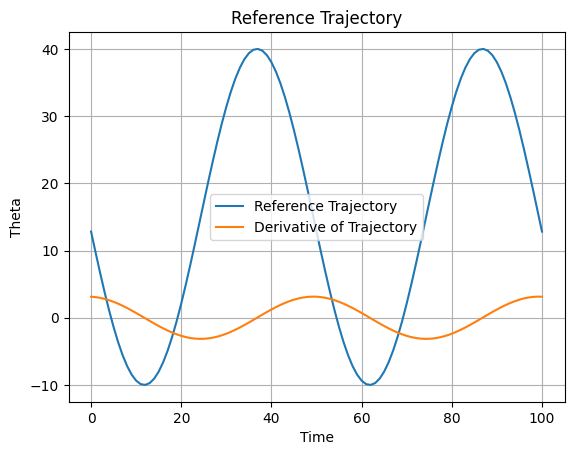

In [6]:
amp = np.deg2rad(25)
freq = 0.02
offset = np.deg2rad(15)
phase = np.deg2rad(5)
time = 100
dt = 1
ref = make_ref_sine(amp, freq, offset, phase)

t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [9]:
psi_vals_deg = np.linspace(-90, 90, 20)
psi_vals_rad = np.deg2rad(psi_vals_deg)

ys = np.array([0.18])
theta_vs_psi = {py: [] for py in ys}
dtheta_dpsi_vs_psi = {py: [] for py in ys}
psi_done = {py: [] for py in ys}

for p_y in ys:
    p_vec = np.array([LENGTH, p_y, 0.0], float)
    for psi_deg in psi_vals_deg:
        try:
            theta_tip, k_star, sol_ivp, info = simulate_beam(
                p_vec=p_vec,
                psi_deg=psi_deg,
                L=LENGTH,
                A_val=A_val,  
                E_val=E_val,
                I_val=I_val,
                MU0=MU0,
                MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                s_steps=200
            )
        except Exception as e:
            print(f"[WARN] skipped p_y={p_y}, psi={psi_deg:.1f}: {e}")
            continue

        theta_vs_psi[p_y].append(np.degrees(theta_tip))
        psi_done[p_y].append(psi_deg)

    print(f"p_y={p_y}: filled {len(psi_done[p_y])}/{len(psi_vals_deg)} points")



p_y=0.18: filled 20/20 points


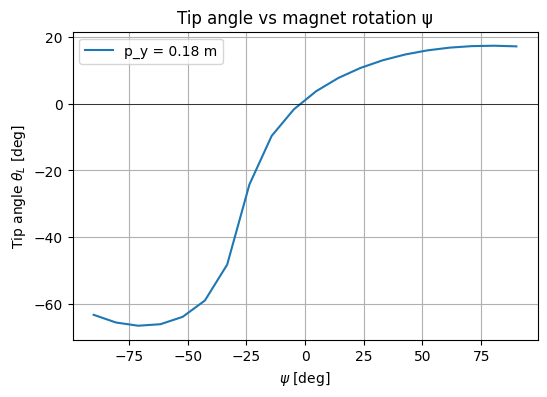

In [10]:
plt.figure(figsize=(6,4))
for p_y in ys:
    plt.plot(psi_vals_deg, theta_vs_psi[p_y], label=f"p_y = {p_y} m")
plt.axhline(0, color='k', lw=0.5)
plt.xlabel(r"$\psi$ [deg]")
plt.ylabel(r"Tip angle $\theta_L$ [deg]")
plt.legend()
plt.title("Tip angle vs magnet rotation ψ")
plt.grid(True)
plt.show()


In [33]:

# psi_vals_deg = np.linspace(-90, 90, 20)
psi_vals_rad = np.linspace(-3,3,20)
# ys = np.array([0.18])   
ys = np.array([0.18])

theta_vs_psi = {py: [] for py in ys}
dtheta_dpsi_vs_psi = {py: [] for py in ys}
psi_done = {py: [] for py in ys}
packs = {py: [] for py in ys} 

for p_y in ys:
    p_vec = np.array([0.0, p_y, 0.0], float)
    for psi_rad in psi_vals_rad:
        try:
            theta_tip, J_tip, pack = jacobian_tip_from_sim2(
                p_vec, psi_rad,
                L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
                MU0=MU0, MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                GRAD_SCALE=1.0, s_steps=400
            )
        except Exception as e:
            print(f"[WARN] skipped p_y={p_y}, psi={psi_rad:.1f}: {e}")
            continue

        theta_vs_psi[p_y].append(np.degrees(theta_tip))
        dtheta_dpsi_vs_psi[p_y].append(J_tip)            
        psi_done[p_y].append(psi_rad)
        packs[p_y].append(pack)

    print(f"p_y={p_y}: filled {len(psi_done[p_y])}/{len(psi_vals_rad)} points")


p_y=0.18: filled 20/20 points


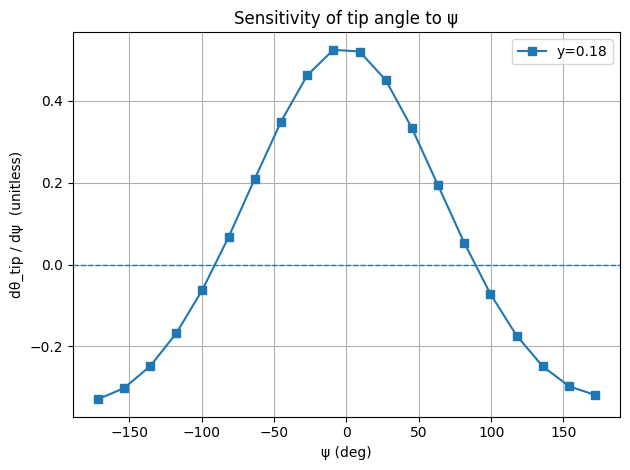

In [35]:
plt.figure()
for p_y in ys:                         
    ps = np.array(psi_done[p_y])
    J  = np.array(dtheta_dpsi_vs_psi[p_y])
    order = np.argsort(ps)
    plt.plot(np.degrees(ps[order]),          
             J[order], marker='s', label=f"y={p_y:.2f}")
plt.axhline(0, linestyle='--', linewidth=1)
plt.xlabel("ψ (deg)")                    
plt.ylabel("dθ_tip / dψ  (unitless)")
plt.title("Sensitivity of tip angle to ψ")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


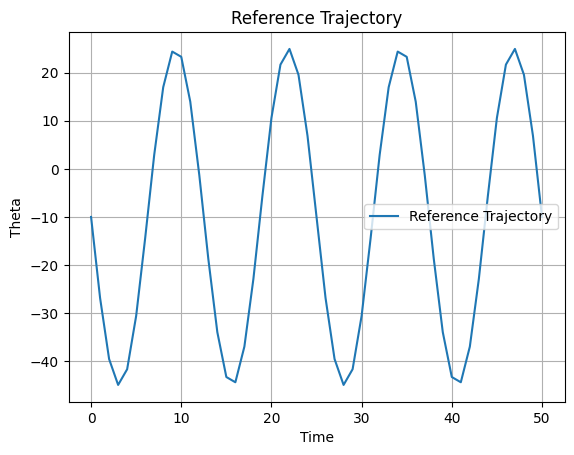

In [64]:
p_vec = np.array([LENGTH, 0.18, 0.0])
A_deg = np.deg2rad(35)      
f_hz = 0.08   
offset_deg = np.deg2rad(-10.0)  
phase_deg = 0.0  
time = 50.0          
dt = 1    
Np = 3   
ref = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
# plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [11]:

out = simple_mpc(
    ref, time, dt, p_vec,
    Np=1,
    w_th=10.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/3106375270.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/1411852970.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-1.559710,  lambda_cl=+0.417960

[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=7.04°  max|θ̂-R|=1.89°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -7.04 |        -7.04 |       -7.01 |       -2.90 |       -4.79 |         +1.89
lam_min(C^T Q C)=1.39e+00  rho=7.18e-01
L=-1.550419,  lambda_cl=+0.401918

[Rollout] k=1  t=1.000s  ψ_k=-7.01°  max|Δψ|=9.28°  max|θ̂-R|=2.41°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -9.28 |        -9.28 |      -16.29 |       -6.49 |       -8.90 |         +2.41
lam_min(C^T Q C)=1.49e+00  rho=6.72e-01
L=-1.548886,  lambda_cl=+0.399525

[Rollout] k=2  t=2.000s  ψ_k=-16.29°  max|Δψ|=7.82°  max|θ̂-R|=2.02°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_

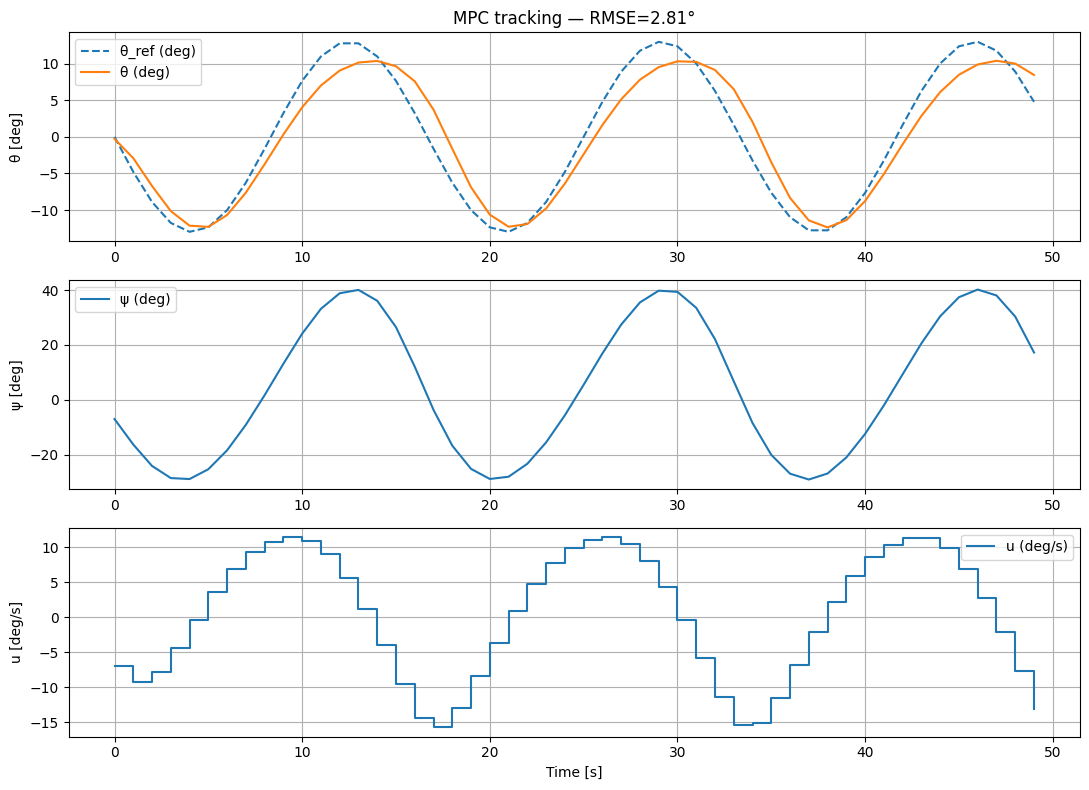

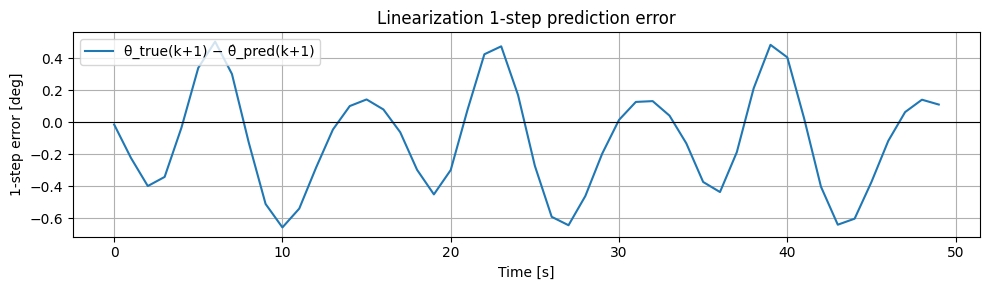

In [12]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [13]:

out = simple_mpc(
    ref, time, dt, p_vec,
    Np=4,
    w_th=10.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/3106375270.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/1411852970.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-1.805541,  lambda_cl=+0.326223

[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=31.58°  max|θ̂-R|=0.98°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -11.18 |       -11.18 |      -11.15 |       -4.44 |       -4.79 |         +0.34
 2 |        -9.91 |       -21.09 |      -21.06 |       -8.14 |       -8.90 |         +0.76
 3 |        -7.08 |       -28.16 |      -28.14 |      -10.78 |      -11.76 |         +0.98
 4 |        -3.42 |       -31.58 |      -31.55 |      -12.06 |      -12.97 |         +0.92
lam_min(C^T Q C)=3.94e-01  rho=2.54e+00
L=-1.767571,  lambda_cl=+0.312587

[Rollout] k=1  t=1.000s  ψ_k=-11.15°  max|Δψ|=19.86°  max|θ̂-R|=0.89°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -9.41 |        

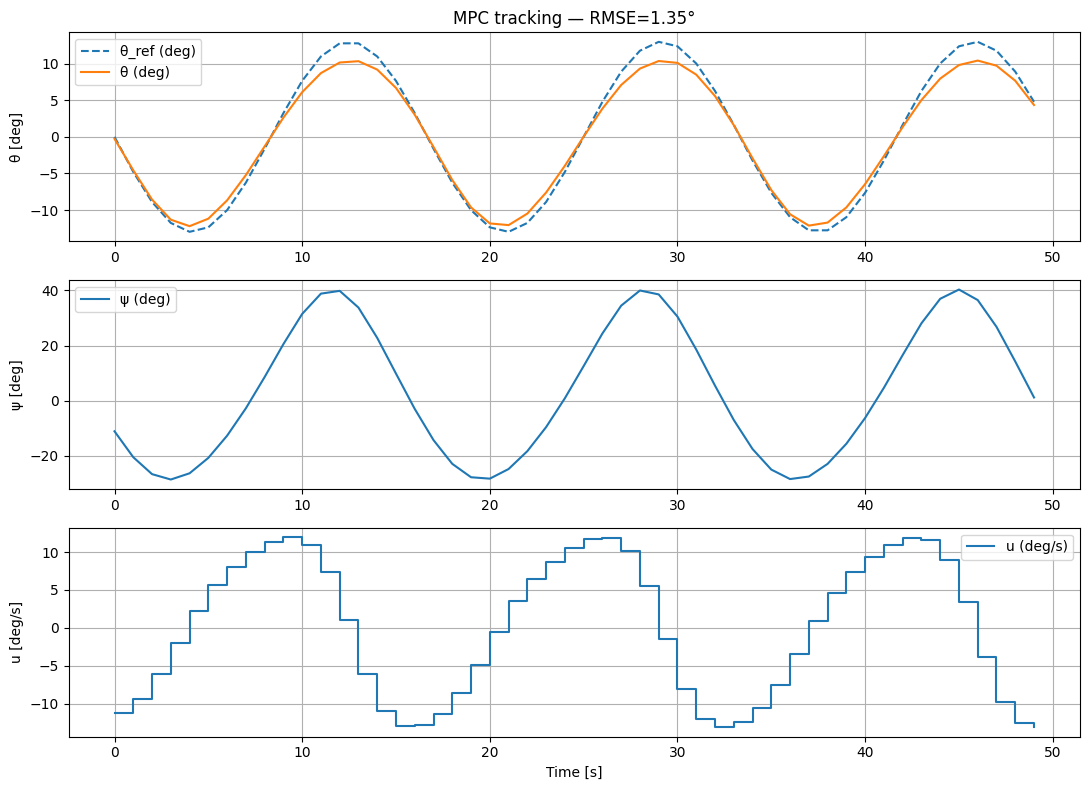

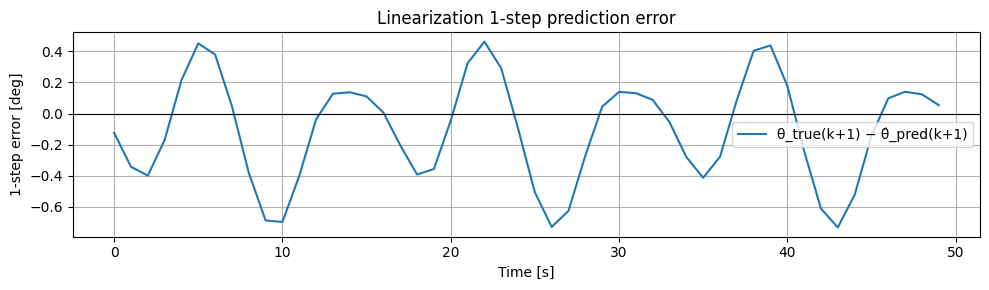

In [14]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [15]:

out = simple_mpc(
    ref, time, dt, p_vec,
    Np=4,
    w_th=100.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/3106375270.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/1411852970.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-2.510797,  lambda_cl=+0.063041

[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=33.80°  max|θ̂-R|=0.11°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -12.01 |       -12.01 |      -11.98 |       -4.76 |       -4.79 |         +0.03
 2 |       -10.87 |       -22.88 |      -22.85 |       -8.81 |       -8.90 |         +0.09
 3 |        -7.60 |       -30.48 |      -30.45 |      -11.65 |      -11.76 |         +0.11
 4 |        -3.32 |       -33.80 |      -33.77 |      -12.89 |      -12.97 |         +0.09
lam_min(C^T Q C)=3.94e+00  rho=2.54e-01
L=-2.419539,  lambda_cl=+0.058542

[Rollout] k=1  t=1.000s  ψ_k=-11.98°  max|Δψ|=20.44°  max|θ̂-R|=0.11°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -10.07 |       -

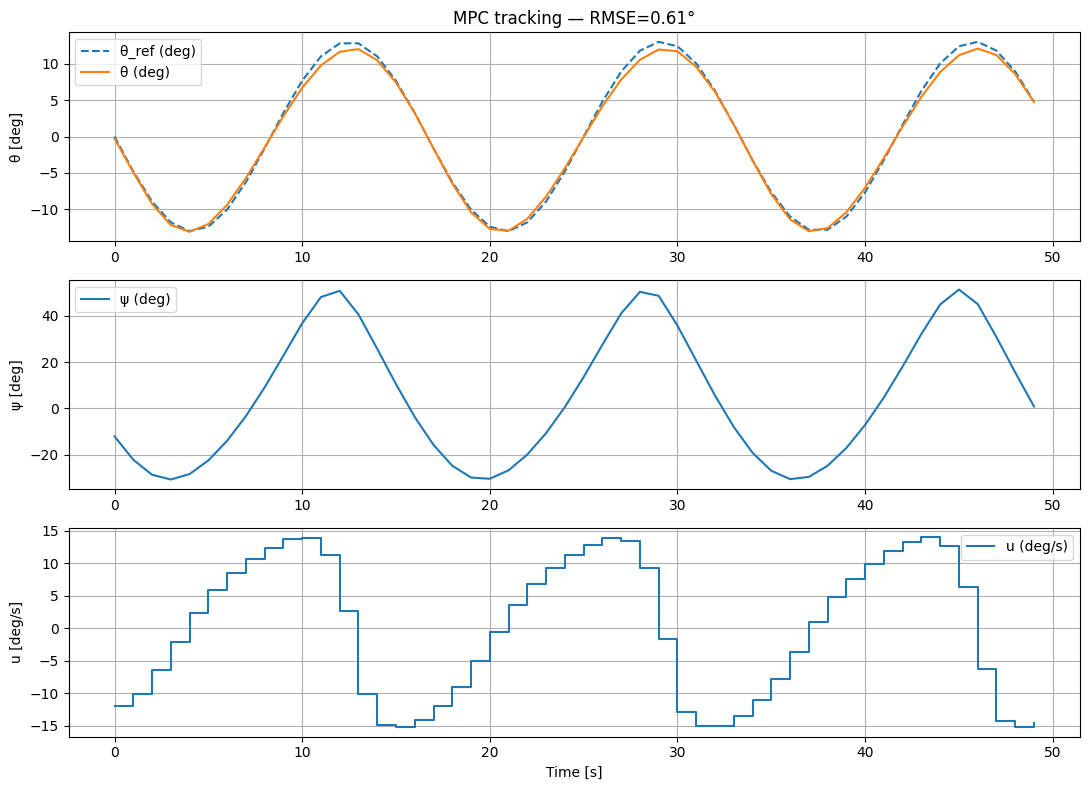

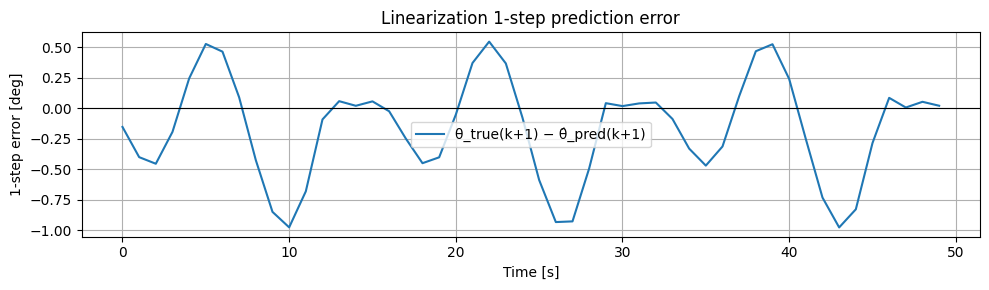

In [16]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [ ]:
def validate_linearization_at(psi_k_deg, *, p_vec, dmax_deg=20.0, n_pts=41, s_steps=200):

    psi_k = np.deg2rad(psi_k_deg)

    def measure_theta(psi_rad):
        th, _, _, _ = simulate_beam(
            p_vec, np.rad2deg(psi_rad),
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s, s_steps=s_steps
        )
        return float(th)

    def jacobian_at(psi_rad):
        _, Jpsi, _ = jacobian_tip_from_sim2(
            p_vec, np.rad2deg(psi_rad),
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s, s_steps=s_steps
        )
        return float(Jpsi)

    theta0 = measure_theta(psi_k)
    J0     = jacobian_at(psi_k)

    dpsi_list = np.linspace(-np.deg2rad(dmax_deg), np.deg2rad(dmax_deg), n_pts)
    theta_true = np.array([measure_theta(psi_k + d) for d in dpsi_list])
    theta_lin  = theta0 + J0 * dpsi_list

    err = theta_true - theta_lin
    rmse = float(np.sqrt(np.mean(err**2)))
    max_abs = float(np.max(np.abs(err)))

    print(f"ψk={psi_k_deg:.2f} deg:  J0={J0:.4g} rad/rad,  RMSE={np.degrees(rmse):.4f} deg,  max|err|={np.degrees(max_abs):.4f} deg")

    plt.figure()
    plt.plot(np.degrees(psi_k + dpsi_list), np.degrees(theta_true), label="θ true")
    plt.plot(np.degrees(psi_k + dpsi_list), np.degrees(theta_lin),  "--", label="θ linear")
    plt.xlabel("ψ [deg]"); plt.ylabel("θ [deg]"); plt.title(f"Linearization @ p={np.array(p_vec)}")
    plt.grid(True); plt.legend()

    plt.figure()
    plt.plot(np.degrees(dpsi_list), np.degrees(err))
    plt.xlabel("Δψ [deg]"); plt.ylabel("θ_true - θ_lin [deg]")
    plt.title("Linearization error vs Δψ")
    plt.grid(True)

    return dict(
        p_vec=np.array(p_vec, float),
        psi_k_deg=float(psi_k_deg),
        J0=float(J0),
        theta0=float(theta0),
        rmse=rmse,
        max_abs=max_abs,
    )


ψk=30.55 deg:  J0=0.2079 rad/rad,  RMSE=0.0374 deg,  max|err|=0.1010 deg


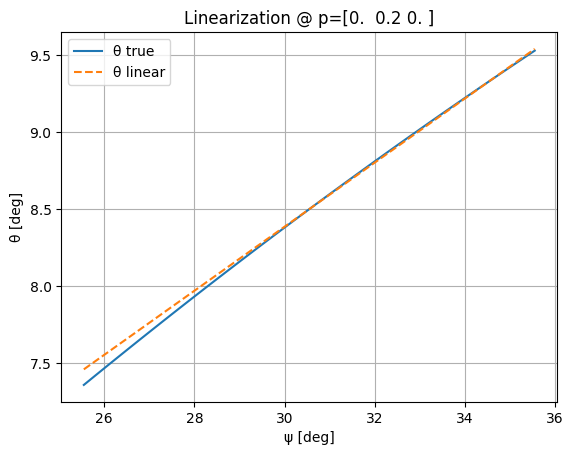

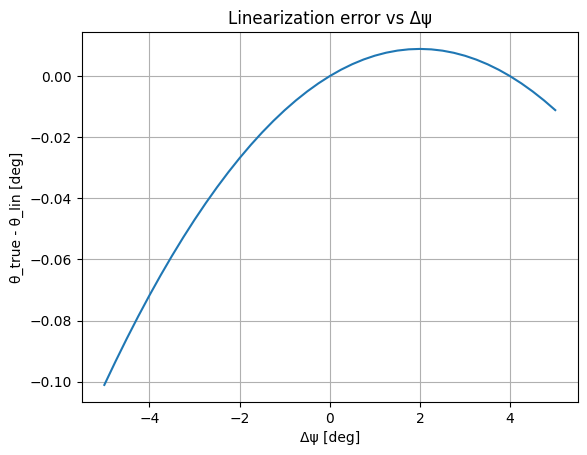

In [ ]:
k = -1
# reconstruct ψ before applying u at step k:
psi_before_deg = out["psi_deg"][k] - out["u_deg_s"][k]*dt
res = validate_linearization_at(psi_before_deg, p_vec=p_vec, dmax_deg=5.0, n_pts=41)


ψk=31.83 deg:  J0=0.2748 rad/rad,  RMSE=1.1330 deg,  max|err|=2.9391 deg


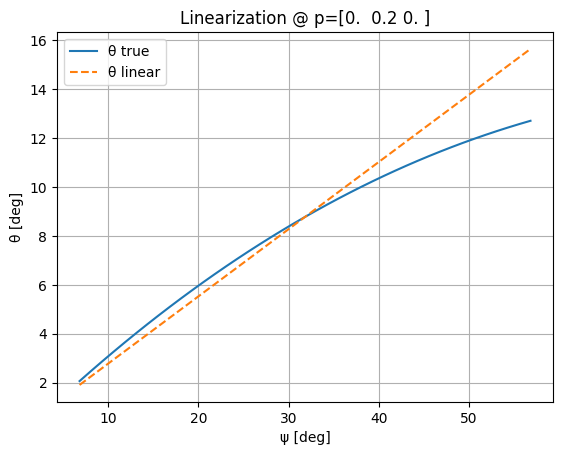

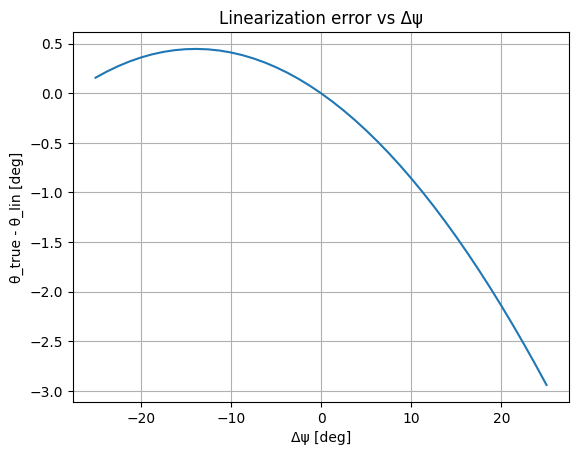

In [ ]:
k = -1
psi_before_deg = out["psi_deg"][k] - out["u_deg_s"][k]*dt
res = validate_linearization_at(psi_before_deg, p_vec=p_vec, dmax_deg=25.0, n_pts=41)


Now a trust region is developed to ensure the change in EPM rotation does not cause linearisation erros. To do this we will take the gradient of the jacobian which will approximate the curvature of the sensitivity. This then defines the linearisation limits by defining the maximum linearisation error.

In [4]:

def jacobian_at(psi_rad, sim):
    _, Jpsi, _ = jacobian_tip_from_sim2(
        p_vec, np.rad2deg(psi_rad),sim=sim
    )
    return float(Jpsi)

def trust_region(jacobian_at, h,psi_rad, error):
    Jp = jacobian_at(psi+h)
    Jm = jacobian_at(psi-h)
    Jprime = (Jp-Jm)/(2*h)
    all_error = np.deg2rad(error)
    L = max(Jprime, 1e-5)
    dpsi_max = np.sqrt((2*all_error)/(L))
    return dpsi_max

We now apply the constraints and solve the minimisation problem. To do this we import a library which is a QP solver.

In [6]:
def mpc_stack(A, B, Q, R, Qf, N):
    n, m = A.shape[0], B.shape[1]
    M, C = seq_mat(A, B, N)
    Qtil = diag_bl(Q, N-1)
    Qtil = np.block([
        [Qtil, np.zeros(((N-1)*n, n))],
        [np.zeros((n, (N-1)*n)), Qf]
    ])
    Rtil = diag_bl(R, N)
    return M, C, Qtil, Rtil

def mpc_cost(M, C, Qtil, Rtil, xk, xref_seq):
    H = 2.0 * (C.T @ Qtil @ C + Rtil)
    F = 2.0 *  C.T @ Qtil @ (M @ xk - xref_seq)
    H = 0.5 * (H + H.T)
    return H, F


In [7]:
def mpc_step_unconstrained(A, B, Q, R, Qf, N, xk, xref_seq):
    M, C, Qtil, Rtil = mpc_stack(A, B, Q, R, Qf, N)
    H, F = mpc_cost(M, C, Qtil, Rtil, xk, xref_seq)
    U = -np.linalg.solve(H, F)        
    X_pred = M @ xk + C @ U
    return U, X_pred, (H, F, M, C, Qtil)


In [8]:
import numpy as np
import scipy.sparse as sp
import osqp

def solve_qp_osqp(H, F, A, l, u, U_warm=None):
    P = sp.csc_matrix(0.5*(H + H.T))
    q = F.astype(float)
    A = sp.csc_matrix(A)
    prob = osqp.OSQP()
    prob.setup(P=P, q=q, A=A, l=l, u=u, verbose=False, eps_abs=1e-6, eps_rel=1e-6)
    if U_warm is not None:
        prob.warm_start(x=U_warm)
    res = prob.solve()
    if res.info.status_val not in (1, 2):   
        raise RuntimeError(f"OSQP failed: {res.info.status}")
    return res.x, res.y                


In [9]:
def mpc_step_trust_region(A, B, Q, R, Qf, N, xk, xref_seq, dt, dpsi_max):
    M, C, Qtil, Rtil = mpc_stack(A, B, Q, R, Qf, N)
    H, F = mpc_cost(M, C, Qtil, Rtil, xk, xref_seq)

    S = np.tril(np.ones((N, N), float)) * dt

    l = -np.ones(N) * dpsi_max
    u = +np.ones(N) * dpsi_max
    U, y = solve_qp_osqp(H, F, S, l, u)

    X_pred = M @ xk + C @ U
    return U, X_pred, (H, F, M, C, Qtil, S, (l, u), y)


In [10]:
PLANT = dict(A_val=A_val, E_val=E_val, I_val=I_val, MU0=MU0, MAGNET_M=MAGNET_M, GRAD_SCALE=1.0)
MODEL = dict(
    A_val=1.05*A_val,          # +5% axial area error
    E_val=0.92*E_val,          # -8% Young's modulus error
    I_val=1.10*I_val,          # +10% inertia error
    MU0=MU0, MAGNET_M=0.95*MAGNET_M,  # magnetization under-rated
    GRAD_SCALE=0.9             # overall field gradient underestimation
)

In [ ]:
def jacobian_at(psi_rad, sim_for_curvature):
    _, Jpsi, _ = jacobian_tip_from_sim2(
        p_vec, psi_rad, L=LENGTH, **PLANT, m_line_of_s=m_line_of_s,
        s_steps=sim_for_curvature.get("s_steps", 10), sim=sim_for_curvature
    )
    return float(Jpsi)


def trust_radius(jac_fn, psi_rad, h_rad=np.deg2rad(0.5), eps_theta_rad=np.deg2rad(1.0)):
    Jp = jac_fn(psi_rad + h_rad)
    Jm = jac_fn(psi_rad - h_rad)
    Jprime = (Jp - Jm) / (2*h_rad)   
    L = max(abs(Jprime), 1e-6)            
    return np.sqrt(2.0*eps_theta_rad / L)


In [88]:
def mpc_compare_logged(ref, T, dt, p_vec, *,
                       Np=15, w_th=1.0, w_u=1e-3,
                       psi0_rad=0.0, J_min=1e-5, s_steps=10,
                       eps_theta_deg=10.0, h_deg_for_radius=0.5,sigma_theta_meas_deg=0.2):


    S = np.tril(np.ones((Np, Np), float)) * dt

    log = dict(
        t=[], theta_ref_deg=[],

        psi_free_deg=[], u_free_deg_s=[], theta0_free_deg=[], theta_pred_free_k1_deg=[],
        psi_tr_deg=[],   u_tr_deg_s=[],   theta0_tr_deg=[],   theta_pred_tr_k1_deg=[],

        dpsi_max_deg=[], viol_free_deg=[], viol_tr_deg=[], du0_deg_s=[],
        active_upper_cnt=[], active_lower_cnt=[],

        theta_true_next_free_deg=[], theta_true_next_tr_deg=[],
    )
    rng = np.random.default_rng(2)
    
    sigma_theta_meas = np.deg2rad(sigma_theta_meas_deg)

    psi_free = float(psi0_rad)
    psi_tr   = float(psi0_rad)

    N = int(round(T/dt))
    for k in range(N):
        t = k*dt

        psi_k_free = psi_free
        theta0_free, _, sol_true_fr, info_true_fr = simulate_beam(
            p_vec, np.rad2deg(psi_k_free), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val
        )
        sol_noisy_fr = types.SimpleNamespace()
        sol_noisy_fr.t = sol_true_fr.t.copy()
        sol_noisy_fr.y = sol_true_fr.y.copy()
        sol_noisy_fr.y[0, :] += rng.normal(0.0, sigma_theta_meas, size=sol_noisy_fr.y[0,:].shape)

        sim_noisy_free = {"theta_tip": float(sol_noisy_fr.y[0,-1]), "sol_ivp": sol_noisy_fr, "info": info_true_fr}


        _, J0_free, _ = jacobian_tip_from_sim2(
            p_vec, psi_k_free, L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
            GRAD_SCALE=1.0, s_steps=s_steps, sim=sim_noisy_free
        )

 
        A_th = np.array([[1.0]])
        B_th_free = np.array([[max(abs(J0_free), J_min) * np.sign(J0_free) * dt]])
        Q_th = np.array([[w_th]]); R_u = np.array([[w_u]]); Qf_th = Q_th
        theta_meas_free = float(sol_noisy_fr.y[0, -1])
        xk_free = np.array([theta_meas_free])
        

        # xk_free = np.array([theta0_free])
        xref = np.array([ref(t + (i+1)*dt)[0] for i in range(Np)], float)

        U_free, X_free, _ = mpc_step_unconstrained(A_th, B_th_free, Q_th, R_u, Qf_th, Np, xk_free, xref)
        u0_free = float(U_free[0])
        # ANGLE_LIM_RAD = np.deg2rad(90.0)

        # u0_free = float(U_free[0])
        # u_min = (-ANGLE_LIM_RAD - psi_free) / dt
        # u_max = ( +ANGLE_LIM_RAD - psi_free) / dt
        # u0_free = float(np.clip(u0_free, u_min, u_max))
        # psi_free_next = psi_free + u0_free * dt
        psi_free_next = psi_free + u0_free*dt


        psi_k_tr = psi_tr
        theta0_tr, _, sol_true_tr, info_true_tr = simulate_beam(
            p_vec, np.rad2deg(psi_k_tr), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val
        )
        sol_noisy_tr = types.SimpleNamespace()
        sol_noisy_tr.t = sol_true_tr.t.copy()
        sol_noisy_tr.y = sol_true_tr.y.copy()
        sol_noisy_tr.y[0, :] += rng.normal(0.0, sigma_theta_meas, size=sol_noisy_tr.y[0,:].shape)

        sim_noisy_tr = {"theta_tip": float(sol_noisy_tr.y[0,-1]), "sol_ivp": sol_noisy_tr, "info": info_true_tr}


        _, J0_tr, _ = jacobian_tip_from_sim2(
            p_vec, psi_k_tr, L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
            GRAD_SCALE=1.0, s_steps=s_steps, sim=sim_noisy_tr
        )

        B_th_tr = np.array([[max(abs(J0_tr), J_min) * np.sign(J0_tr) * dt]])
        # xk_tr = np.array([theta0_tr])
        theta_meas_tr   = float(sol_noisy_tr.y[0, -1])
        xk_tr   = np.array([theta_meas_tr])
        eps_theta_rad = np.deg2rad(eps_theta_deg)
        dpsi_max = trust_radius(lambda psiq: jacobian_at(psiq, sim_noisy_tr),
                                psi_k_tr, h_rad=np.deg2rad(h_deg_for_radius),
                                eps_theta_rad=eps_theta_rad)

        U_tr, X_tr, tr_pack = mpc_step_trust_region(A_th, B_th_tr, Q_th, R_u, Qf_th,
                                                    Np, xk_tr, xref, dt, dpsi_max)
        u0_tr = float(U_tr[0])
        psi_tr_next = psi_tr + u0_tr*dt


        viol_free = float(np.max(np.abs(S @ U_free)))
        viol_tr   = float(np.max(np.abs(S @ U_tr)))

     
        y_dual = tr_pack[-1]
        act_upper = int(np.sum(y_dual > +1e-6))
        act_lower = int(np.sum(y_dual < -1e-6))


        theta_true_next_free, *_ = simulate_beam(
            p_vec, np.rad2deg(psi_free_next), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val
        )
        theta_true_next_tr, *_ = simulate_beam(
            p_vec, np.rad2deg(psi_tr_next), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val
        )

        log["t"].append(t)
        log["theta_ref_deg"].append(np.degrees(xref[0]))

        log["psi_free_deg"].append(np.degrees(psi_free))
        log["u_free_deg_s"].append(np.degrees(u0_free))
        log["theta0_free_deg"].append(np.degrees(theta0_free))
        log["theta_pred_free_k1_deg"].append(np.degrees(X_free[0]))

        log["psi_tr_deg"].append(np.degrees(psi_tr))
        log["u_tr_deg_s"].append(np.degrees(u0_tr))
        log["theta0_tr_deg"].append(np.degrees(theta0_tr))
        log["theta_pred_tr_k1_deg"].append(np.degrees(X_tr[0]))

        log["dpsi_max_deg"].append(np.degrees(dpsi_max))
        log["viol_free_deg"].append(np.degrees(viol_free))
        log["viol_tr_deg"].append(np.degrees(viol_tr))
        log["du0_deg_s"].append(np.degrees(u0_tr - u0_free))
        log["active_upper_cnt"].append(act_upper)
        log["active_lower_cnt"].append(act_lower)

        log["theta_true_next_free_deg"].append(np.degrees(theta_true_next_free))
        log["theta_true_next_tr_deg"].append(np.degrees(theta_true_next_tr))

        psi_free = psi_free_next
        psi_tr   = psi_tr_next


        print(f"[k={k}] dψ_max={np.degrees(dpsi_max):.2f}° | "
              f"‖S U_free‖∞={np.degrees(viol_free):.2f}° | "
              f"‖S U_tr‖∞={np.degrees(viol_tr):.2f}° | "
              f"Δu0={np.degrees(u0_tr-u0_free):+.2f} °/s | "
              f"act(↑,↓)=({act_upper},{act_lower})")


    for k in list(log.keys()):
        if k not in ("Np","dt"):
            log[k] = np.asarray(log[k], float)
    log["Np"] = Np; log["dt"] = dt
    return log


In [13]:
# log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
#                          Np=4, w_th=100.0, w_u=1.0,
#                          psi0_rad=np.deg2rad(-25), J_min=1e-5,
#                          s_steps=400, eps_theta_deg=10.0)

# t = log["t"]
# plt.figure(figsize=(11,8))
# ax1 = plt.subplot(3,1,1)
# ax1.plot(t, log["theta_ref_deg"], "k--", label="θ_ref")
# ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
# ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
# ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)

# ax2 = plt.subplot(3,1,2, sharex=ax1)
# ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
# ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
# ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

# ax3 = plt.subplot(3,1,3, sharex=ax1)
# ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
# ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
# ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
# ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
# plt.tight_layout(); plt.show()


In [58]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=4, w_th=100.0, w_u=1.0,
                         psi0_rad=np.deg2rad(-15), J_min=1e-5,
                         s_steps=400, eps_theta_deg=0.5)



[k=0] dψ_max=18.27° | ‖S U_free‖∞=38.11° | ‖S U_tr‖∞=18.27° | Δu0=+0.54 °/s | act(↑,↓)=(0,3)
[k=1] dψ_max=6.89° | ‖S U_free‖∞=27.72° | ‖S U_tr‖∞=6.89° | Δu0=-10.37 °/s | act(↑,↓)=(4,0)
[k=2] dψ_max=8.21° | ‖S U_free‖∞=35.81° | ‖S U_tr‖∞=8.21° | Δu0=+27.60 °/s | act(↑,↓)=(1,1)
[k=3] dψ_max=6.90° | ‖S U_free‖∞=241.67° | ‖S U_tr‖∞=6.90° | Δu0=-88.58 °/s | act(↑,↓)=(4,0)
[k=4] dψ_max=7.69° | ‖S U_free‖∞=174.56° | ‖S U_tr‖∞=7.69° | Δu0=+180.49 °/s | act(↑,↓)=(3,0)
[k=5] dψ_max=10.98° | ‖S U_free‖∞=91.48° | ‖S U_tr‖∞=10.98° | Δu0=+41.02 °/s | act(↑,↓)=(3,0)
[k=6] dψ_max=17.14° | ‖S U_free‖∞=53.78° | ‖S U_tr‖∞=17.14° | Δu0=+32.01 °/s | act(↑,↓)=(3,0)
[k=7] dψ_max=20.01° | ‖S U_free‖∞=45.62° | ‖S U_tr‖∞=20.01° | Δu0=+50.19 °/s | act(↑,↓)=(3,0)
[k=8] dψ_max=14.63° | ‖S U_free‖∞=39.85° | ‖S U_tr‖∞=14.63° | Δu0=+45.55 °/s | act(↑,↓)=(2,1)
[k=9] dψ_max=14.15° | ‖S U_free‖∞=189.05° | ‖S U_tr‖∞=14.15° | Δu0=+14.50 °/s | act(↑,↓)=(1,2)
[k=10] dψ_max=14.23° | ‖S U_free‖∞=276.89° | ‖S U_tr‖∞=14.23° | Δ

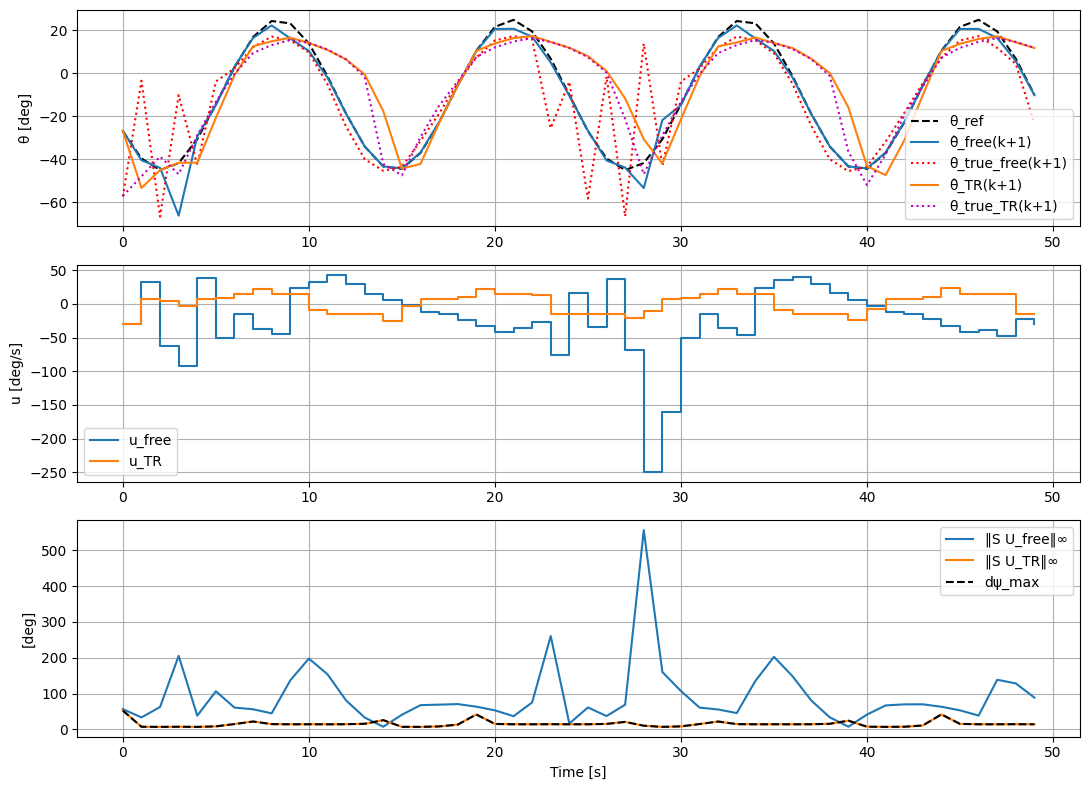

In [66]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

In [65]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=100.0, w_u=1.0,
                         psi0_rad=np.deg2rad(-10), J_min=1e-5,
                         s_steps=400, eps_theta_deg=0.5)



[k=0] dψ_max=52.51° | ‖S U_free‖∞=56.54° | ‖S U_tr‖∞=52.51° | Δu0=+0.35 °/s | act(↑,↓)=(0,1)
[k=1] dψ_max=7.17° | ‖S U_free‖∞=33.34° | ‖S U_tr‖∞=7.17° | Δu0=-26.17 °/s | act(↑,↓)=(3,0)
[k=2] dψ_max=6.89° | ‖S U_free‖∞=62.47° | ‖S U_tr‖∞=6.89° | Δu0=+66.48 °/s | act(↑,↓)=(2,0)
[k=3] dψ_max=7.20° | ‖S U_free‖∞=205.32° | ‖S U_tr‖∞=7.20° | Δu0=+88.21 °/s | act(↑,↓)=(2,0)
[k=4] dψ_max=6.90° | ‖S U_free‖∞=38.23° | ‖S U_tr‖∞=6.90° | Δu0=-31.33 °/s | act(↑,↓)=(3,0)
[k=5] dψ_max=8.31° | ‖S U_free‖∞=106.29° | ‖S U_tr‖∞=8.31° | Δu0=+58.55 °/s | act(↑,↓)=(3,0)
[k=6] dψ_max=14.80° | ‖S U_free‖∞=60.77° | ‖S U_tr‖∞=14.80° | Δu0=+29.76 °/s | act(↑,↓)=(3,0)
[k=7] dψ_max=21.90° | ‖S U_free‖∞=56.05° | ‖S U_tr‖∞=21.90° | Δu0=+58.80 °/s | act(↑,↓)=(3,0)
[k=8] dψ_max=14.63° | ‖S U_free‖∞=44.74° | ‖S U_tr‖∞=14.63° | Δu0=+59.36 °/s | act(↑,↓)=(2,0)
[k=9] dψ_max=14.15° | ‖S U_free‖∞=136.96° | ‖S U_tr‖∞=14.15° | Δu0=-9.44 °/s | act(↑,↓)=(1,1)
[k=10] dψ_max=14.23° | ‖S U_free‖∞=197.74° | ‖S U_tr‖∞=14.23° | Δu0=-

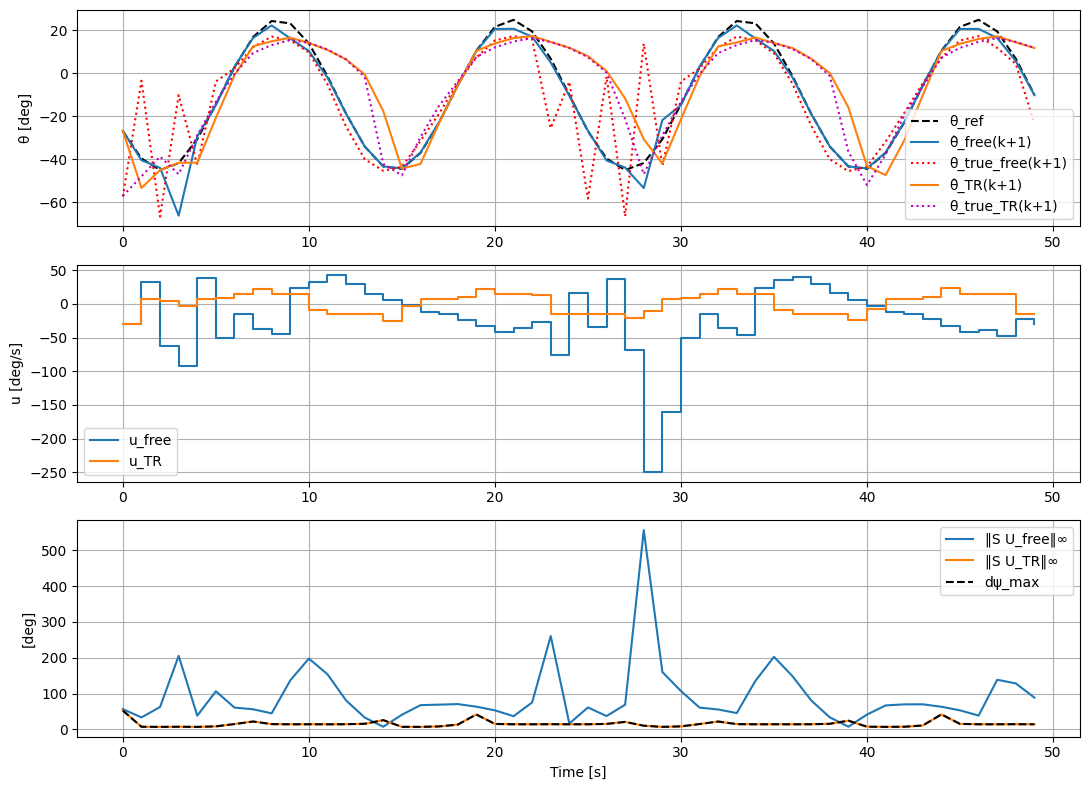

In [68]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

In [69]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=100.0, w_u=1.0,
                         psi0_rad=np.deg2rad(-10), J_min=1e-5,
                         s_steps=400, eps_theta_deg=5.0)



[k=0] dψ_max=166.04° | ‖S U_free‖∞=56.54° | ‖S U_tr‖∞=56.18° | Δu0=+0.35 °/s | act(↑,↓)=(0,0)
[k=1] dψ_max=22.66° | ‖S U_free‖∞=33.34° | ‖S U_tr‖∞=22.66° | Δu0=-10.67 °/s | act(↑,↓)=(3,0)
[k=2] dψ_max=45.87° | ‖S U_free‖∞=62.47° | ‖S U_tr‖∞=37.89° | Δu0=+24.57 °/s | act(↑,↓)=(0,0)
[k=3] dψ_max=25.81° | ‖S U_free‖∞=205.32° | ‖S U_tr‖∞=25.81° | Δu0=+117.51 °/s | act(↑,↓)=(3,0)
[k=4] dψ_max=22.45° | ‖S U_free‖∞=38.23° | ‖S U_tr‖∞=22.45° | Δu0=-27.12 °/s | act(↑,↓)=(2,0)
[k=5] dψ_max=42.37° | ‖S U_free‖∞=106.29° | ‖S U_tr‖∞=37.47° | Δu0=+50.44 °/s | act(↑,↓)=(0,0)
[k=6] dψ_max=43.02° | ‖S U_free‖∞=60.77° | ‖S U_tr‖∞=43.02° | Δu0=+35.59 °/s | act(↑,↓)=(1,0)
[k=7] dψ_max=57.20° | ‖S U_free‖∞=56.05° | ‖S U_tr‖∞=40.68° | Δu0=+63.74 °/s | act(↑,↓)=(0,0)
[k=8] dψ_max=44.97° | ‖S U_free‖∞=44.74° | ‖S U_tr‖∞=37.75° | Δu0=+82.49 °/s | act(↑,↓)=(0,0)
[k=9] dψ_max=46.36° | ‖S U_free‖∞=136.96° | ‖S U_tr‖∞=46.36° | Δu0=-19.28 °/s | act(↑,↓)=(0,1)
[k=10] dψ_max=46.75° | ‖S U_free‖∞=197.74° | ‖S U_tr‖∞=4

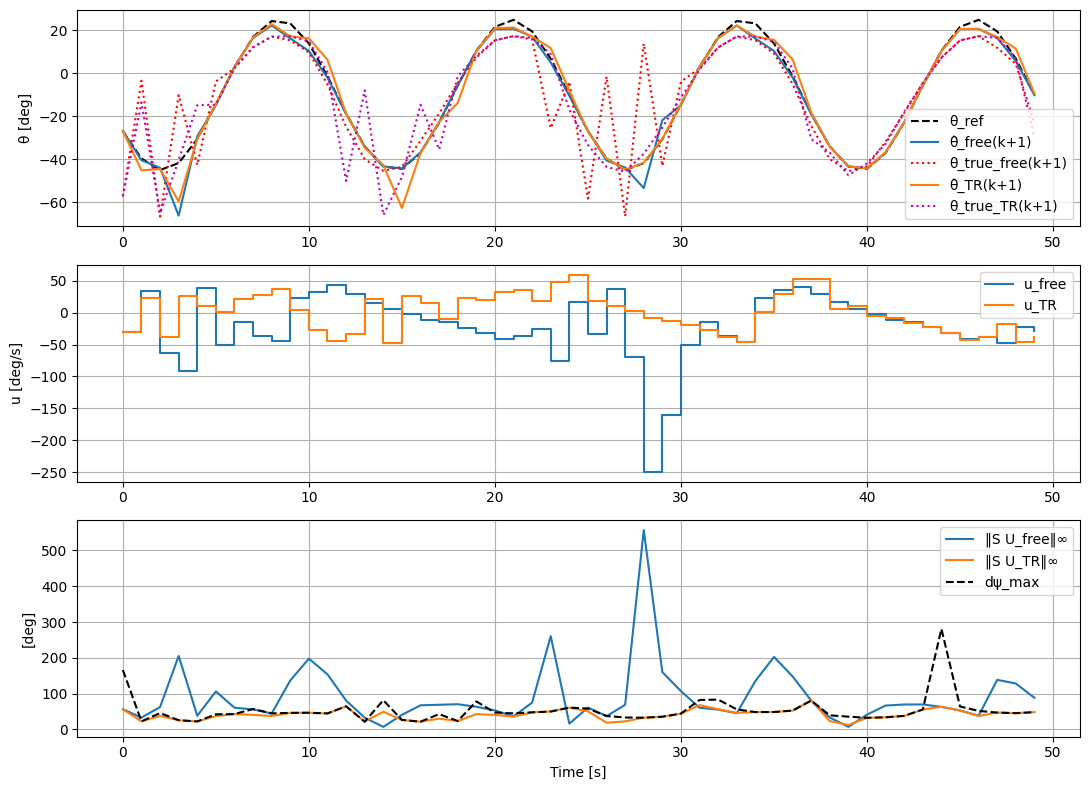

In [72]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

In [ ]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=100.0, w_u=1.0,
                         psi0_rad=np.deg2rad(-10), J_min=1e-5,
                         s_steps=10, eps_theta_deg=1.0)

[k=0] dψ_max=73.98° | ‖S U_free‖∞=56.77° | ‖S U_tr‖∞=56.04° | Δu0=+0.70 °/s | act(↑,↓)=(0,0)
[k=1] dψ_max=10.12° | ‖S U_free‖∞=34.70° | ‖S U_tr‖∞=10.12° | Δu0=-24.58 °/s | act(↑,↓)=(3,0)
[k=2] dψ_max=9.98° | ‖S U_free‖∞=65.66° | ‖S U_tr‖∞=9.98° | Δu0=+61.67 °/s | act(↑,↓)=(1,0)
[k=3] dψ_max=9.75° | ‖S U_free‖∞=549.45° | ‖S U_tr‖∞=9.75° | Δu0=+255.85 °/s | act(↑,↓)=(3,0)
[k=4] dψ_max=12.77° | ‖S U_free‖∞=181.53° | ‖S U_tr‖∞=12.77° | Δu0=+175.83 °/s | act(↑,↓)=(1,0)
[k=5] dψ_max=9.99° | ‖S U_free‖∞=72.95° | ‖S U_tr‖∞=9.99° | Δu0=+31.24 °/s | act(↑,↓)=(3,0)
[k=6] dψ_max=17.06° | ‖S U_free‖∞=66.48° | ‖S U_tr‖∞=17.06° | Δu0=+42.51 °/s | act(↑,↓)=(3,0)
[k=7] dψ_max=31.55° | ‖S U_free‖∞=56.87° | ‖S U_tr‖∞=31.55° | Δu0=+66.90 °/s | act(↑,↓)=(2,0)
[k=8] dψ_max=20.23° | ‖S U_free‖∞=44.73° | ‖S U_tr‖∞=20.23° | Δu0=+64.96 °/s | act(↑,↓)=(2,0)
[k=9] dψ_max=20.09° | ‖S U_free‖∞=140.08° | ‖S U_tr‖∞=20.09° | Δu0=-2.44 °/s | act(↑,↓)=(1,1)
[k=10] dψ_max=20.71° | ‖S U_free‖∞=195.03° | ‖S U_tr‖∞=20.71° |

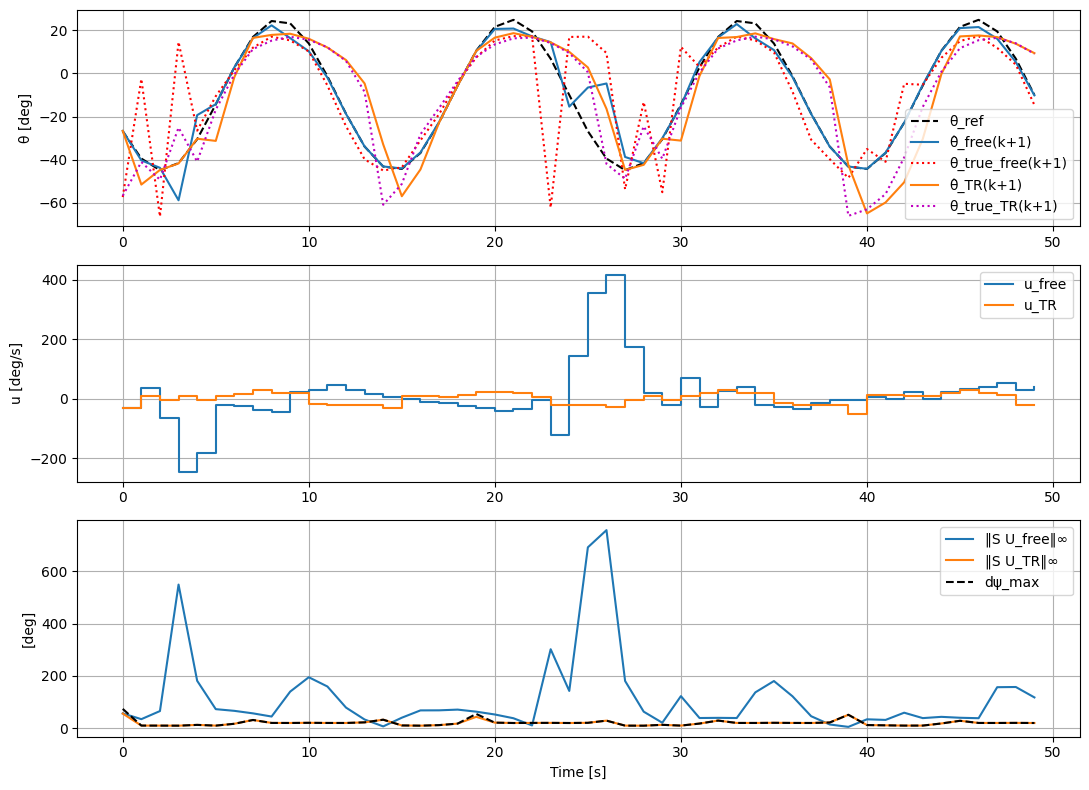

In [78]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

In [80]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=100.0, w_u=1.0,
                         psi0_rad=np.deg2rad(-10), J_min=1e-5,
                         s_steps=10, eps_theta_deg=0.5)

[k=0] dψ_max=52.31° | ‖S U_free‖∞=56.77° | ‖S U_tr‖∞=52.31° | Δu0=+0.70 °/s | act(↑,↓)=(0,1)
[k=1] dψ_max=7.16° | ‖S U_free‖∞=34.70° | ‖S U_tr‖∞=7.16° | Δu0=-27.54 °/s | act(↑,↓)=(3,0)
[k=2] dψ_max=6.89° | ‖S U_free‖∞=65.66° | ‖S U_tr‖∞=6.89° | Δu0=+69.54 °/s | act(↑,↓)=(2,0)
[k=3] dψ_max=7.20° | ‖S U_free‖∞=549.45° | ‖S U_tr‖∞=7.20° | Δu0=+242.36 °/s | act(↑,↓)=(2,0)
[k=4] dψ_max=6.89° | ‖S U_free‖∞=181.53° | ‖S U_tr‖∞=6.89° | Δu0=+188.42 °/s | act(↑,↓)=(3,0)
[k=5] dψ_max=8.19° | ‖S U_free‖∞=72.95° | ‖S U_tr‖∞=8.19° | Δu0=+29.43 °/s | act(↑,↓)=(3,0)
[k=6] dψ_max=14.34° | ‖S U_free‖∞=66.48° | ‖S U_tr‖∞=14.34° | Δu0=+39.78 °/s | act(↑,↓)=(3,0)
[k=7] dψ_max=23.06° | ‖S U_free‖∞=56.87° | ‖S U_tr‖∞=23.06° | Δu0=+61.17 °/s | act(↑,↓)=(3,0)
[k=8] dψ_max=14.61° | ‖S U_free‖∞=44.73° | ‖S U_tr‖∞=14.61° | Δu0=+59.34 °/s | act(↑,↓)=(2,0)
[k=9] dψ_max=14.15° | ‖S U_free‖∞=140.08° | ‖S U_tr‖∞=14.15° | Δu0=-8.38 °/s | act(↑,↓)=(1,1)
[k=10] dψ_max=14.24° | ‖S U_free‖∞=195.03° | ‖S U_tr‖∞=14.24° | Δu0

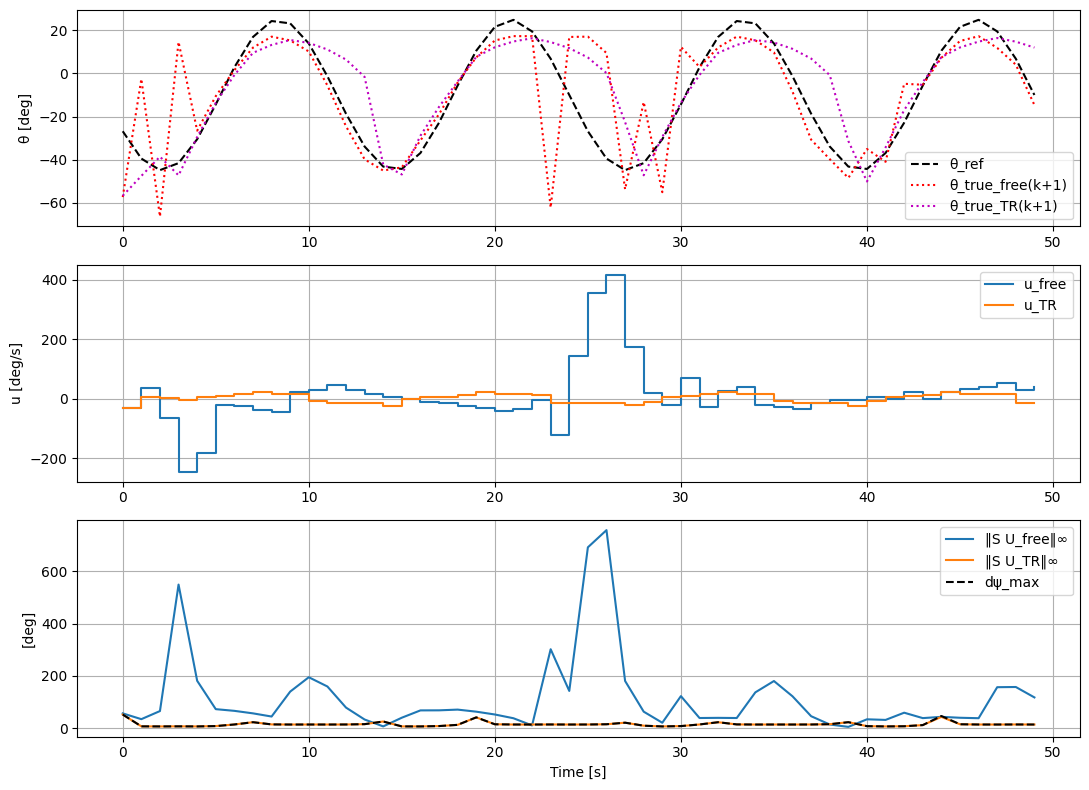

In [82]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
# ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
# ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

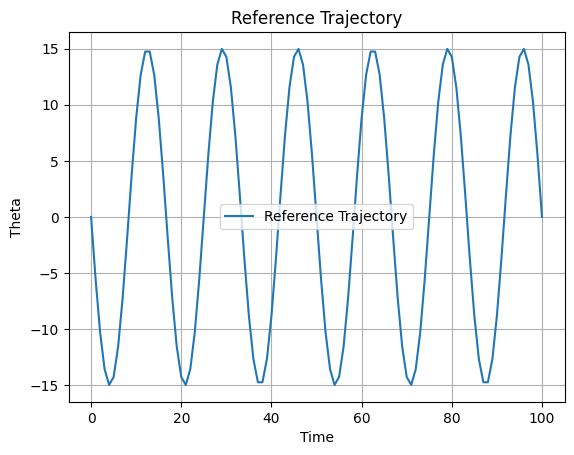

In [112]:
p_vec = np.array([LENGTH, 0.18, 0.0])
A_deg = np.deg2rad(15)      
f_hz = 0.06
offset_deg = np.deg2rad(0.0)  
phase_deg = 0.0  
time = 100.0          
dt = 1    
Np = 3   
ref = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
# plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [94]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=10.0, w_u=1.0,
                         psi0_rad=np.deg2rad(0.0), J_min=1e-5,
                         s_steps=10, eps_theta_deg=0.5, sigma_theta_meas_deg=0.0)

[k=0] dψ_max=19.56° | ‖S U_free‖∞=19.08° | ‖S U_tr‖∞=19.08° | Δu0=-0.00 °/s | act(↑,↓)=(0,0)
[k=1] dψ_max=54.36° | ‖S U_free‖∞=11.88° | ‖S U_tr‖∞=11.88° | Δu0=+0.00 °/s | act(↑,↓)=(0,0)
[k=2] dψ_max=24.79° | ‖S U_free‖∞=8.01° | ‖S U_tr‖∞=8.01° | Δu0=-0.00 °/s | act(↑,↓)=(0,0)
[k=3] dψ_max=17.13° | ‖S U_free‖∞=4.61° | ‖S U_tr‖∞=4.61° | Δu0=+0.00 °/s | act(↑,↓)=(0,0)
[k=4] dψ_max=14.49° | ‖S U_free‖∞=1.68° | ‖S U_tr‖∞=1.68° | Δu0=-0.00 °/s | act(↑,↓)=(0,0)
[k=5] dψ_max=13.43° | ‖S U_free‖∞=1.26° | ‖S U_tr‖∞=1.26° | Δu0=+0.00 °/s | act(↑,↓)=(0,0)
[k=6] dψ_max=13.23° | ‖S U_free‖∞=3.87° | ‖S U_tr‖∞=3.87° | Δu0=+0.00 °/s | act(↑,↓)=(0,0)
[k=7] dψ_max=13.74° | ‖S U_free‖∞=6.31° | ‖S U_tr‖∞=6.31° | Δu0=+0.00 °/s | act(↑,↓)=(0,0)
[k=8] dψ_max=15.11° | ‖S U_free‖∞=8.58° | ‖S U_tr‖∞=8.58° | Δu0=+0.00 °/s | act(↑,↓)=(0,0)
[k=9] dψ_max=18.03° | ‖S U_free‖∞=10.68° | ‖S U_tr‖∞=10.68° | Δu0=+0.00 °/s | act(↑,↓)=(0,0)
[k=10] dψ_max=25.49° | ‖S U_free‖∞=12.59° | ‖S U_tr‖∞=12.59° | Δu0=+0.00 °/s | act(↑

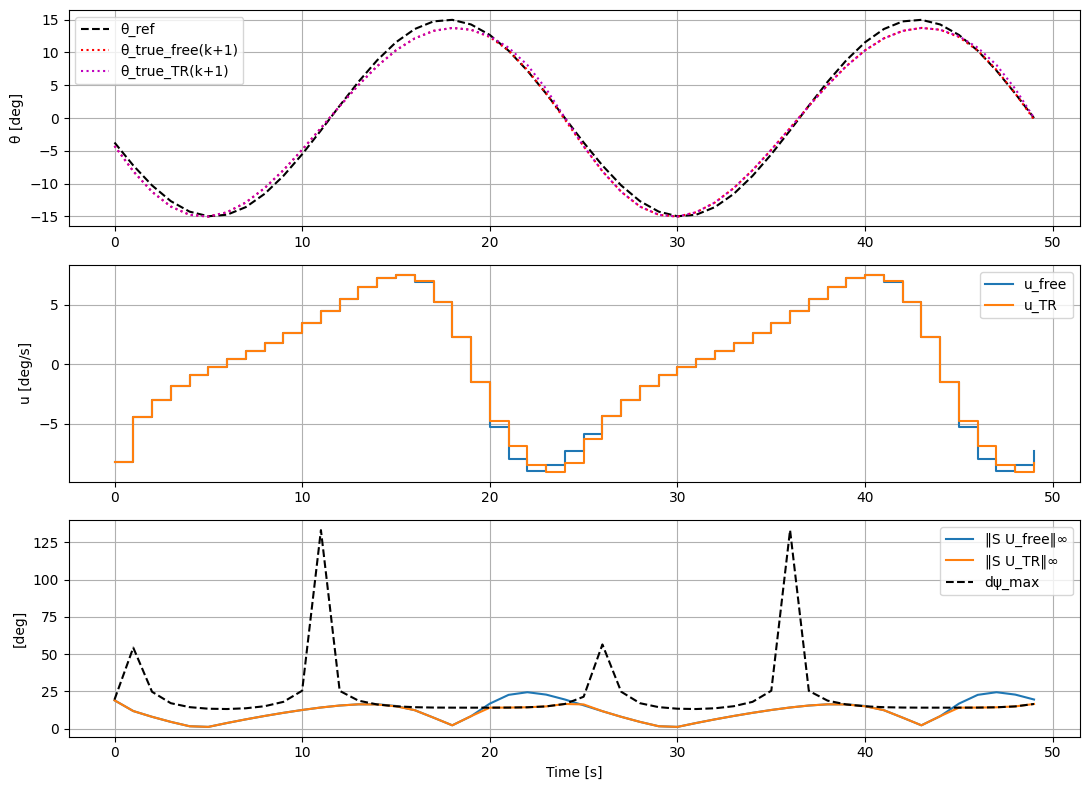

In [96]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
# ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
# ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

In [101]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=10.0, w_u=1.0,
                         psi0_rad=np.deg2rad(0.0), J_min=1e-5,
                         s_steps=10, eps_theta_deg=0.5, sigma_theta_meas_deg=0.7)

[k=0] dψ_max=19.56° | ‖S U_free‖∞=20.06° | ‖S U_tr‖∞=18.54° | Δu0=+1.23 °/s | act(↑,↓)=(0,0)
[k=1] dψ_max=45.13° | ‖S U_free‖∞=9.08° | ‖S U_tr‖∞=12.01° | Δu0=-2.35 °/s | act(↑,↓)=(0,0)
[k=2] dψ_max=26.27° | ‖S U_free‖∞=11.70° | ‖S U_tr‖∞=7.87° | Δu0=+3.21 °/s | act(↑,↓)=(0,0)
[k=3] dψ_max=18.07° | ‖S U_free‖∞=1.53° | ‖S U_tr‖∞=6.48° | Δu0=-4.97 °/s | act(↑,↓)=(0,0)
[k=4] dψ_max=13.21° | ‖S U_free‖∞=6.44° | ‖S U_tr‖∞=0.60° | Δu0=+5.73 °/s | act(↑,↓)=(0,0)
[k=5] dψ_max=13.91° | ‖S U_free‖∞=6.27° | ‖S U_tr‖∞=2.67° | Δu0=-7.01 °/s | act(↑,↓)=(0,0)
[k=6] dψ_max=11.35° | ‖S U_free‖∞=3.18° | ‖S U_tr‖∞=6.11° | Δu0=+5.75 °/s | act(↑,↓)=(0,0)
[k=7] dψ_max=13.77° | ‖S U_free‖∞=8.99° | ‖S U_tr‖∞=6.71° | Δu0=-2.15 °/s | act(↑,↓)=(0,0)
[k=8] dψ_max=15.70° | ‖S U_free‖∞=7.02° | ‖S U_tr‖∞=7.22° | Δu0=+0.23 °/s | act(↑,↓)=(0,0)
[k=9] dψ_max=16.58° | ‖S U_free‖∞=10.28° | ‖S U_tr‖∞=12.13° | Δu0=+1.65 °/s | act(↑,↓)=(0,0)


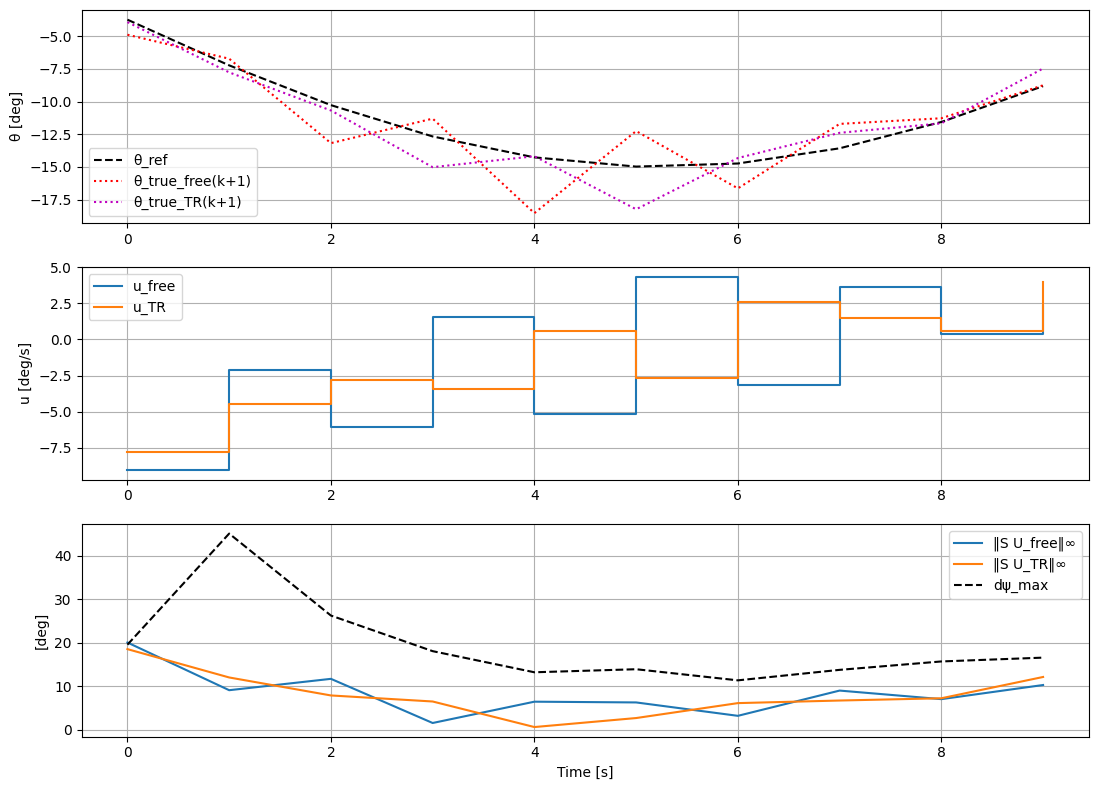

In [104]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
# ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
# ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

In [113]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=10.0, w_u=1.0,
                         psi0_rad=np.deg2rad(0.0), J_min=1e-5,
                         s_steps=10, eps_theta_deg=0.5, sigma_theta_meas_deg=0.5)

[k=0] dψ_max=19.56° | ‖S U_free‖∞=25.45° | ‖S U_tr‖∞=19.56° | Δu0=+1.06 °/s | act(↑,↓)=(0,1)
[k=1] dψ_max=39.09° | ‖S U_free‖∞=9.23° | ‖S U_tr‖∞=11.64° | Δu0=-1.96 °/s | act(↑,↓)=(0,0)
[k=2] dψ_max=16.69° | ‖S U_free‖∞=6.39° | ‖S U_tr‖∞=3.60° | Δu0=+2.46 °/s | act(↑,↓)=(0,0)
[k=3] dψ_max=13.93° | ‖S U_free‖∞=6.28° | ‖S U_tr‖∞=2.03° | Δu0=-3.86 °/s | act(↑,↓)=(0,0)
[k=4] dψ_max=12.44° | ‖S U_free‖∞=5.09° | ‖S U_tr‖∞=9.87° | Δu0=+4.48 °/s | act(↑,↓)=(0,0)
[k=5] dψ_max=15.01° | ‖S U_free‖∞=16.50° | ‖S U_tr‖∞=11.37° | Δu0=-4.88 °/s | act(↑,↓)=(0,0)
[k=6] dψ_max=16.20° | ‖S U_free‖∞=15.27° | ‖S U_tr‖∞=16.20° | Δu0=+2.62 °/s | act(↑,↓)=(1,0)
[k=7] dψ_max=34.08° | ‖S U_free‖∞=20.63° | ‖S U_tr‖∞=20.89° | Δu0=+0.25 °/s | act(↑,↓)=(0,0)
[k=8] dψ_max=24.28° | ‖S U_free‖∞=21.14° | ‖S U_tr‖∞=20.47° | Δu0=-0.58 °/s | act(↑,↓)=(0,0)
[k=9] dψ_max=17.63° | ‖S U_free‖∞=19.66° | ‖S U_tr‖∞=17.63° | Δu0=+1.25 °/s | act(↑,↓)=(1,0)
[k=10] dψ_max=15.19° | ‖S U_free‖∞=19.15° | ‖S U_tr‖∞=15.19° | Δu0=-2.15 °/s 

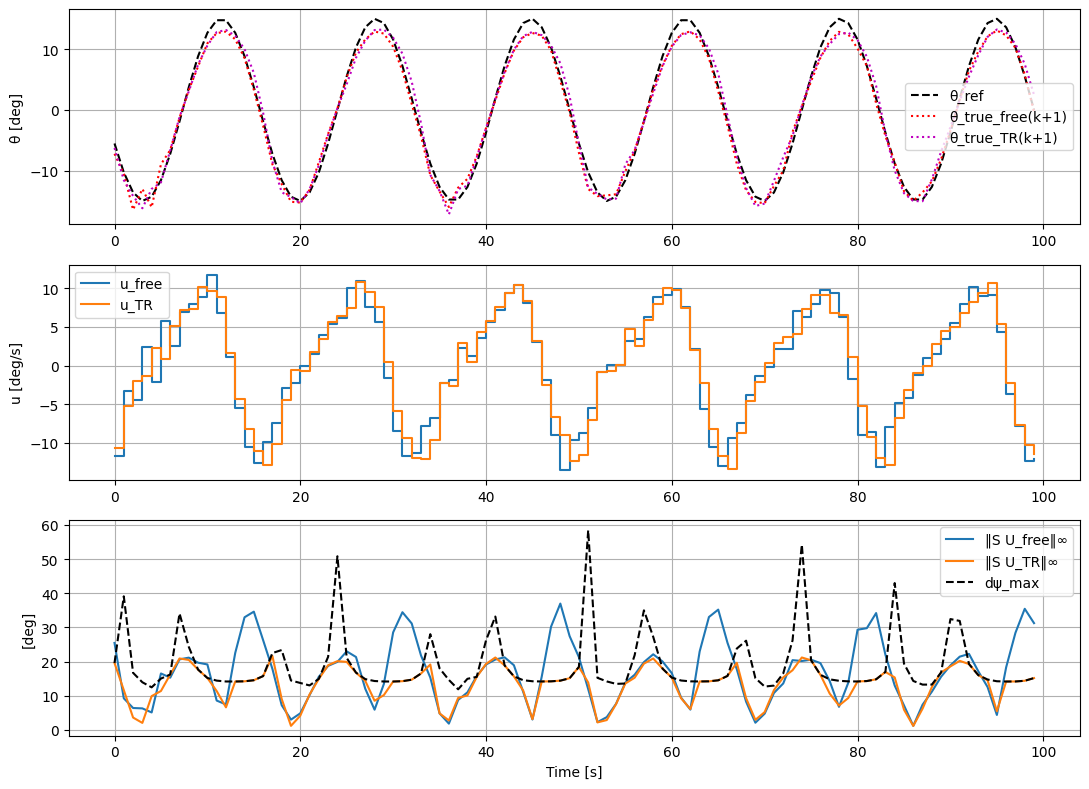

In [115]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
# ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
# ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

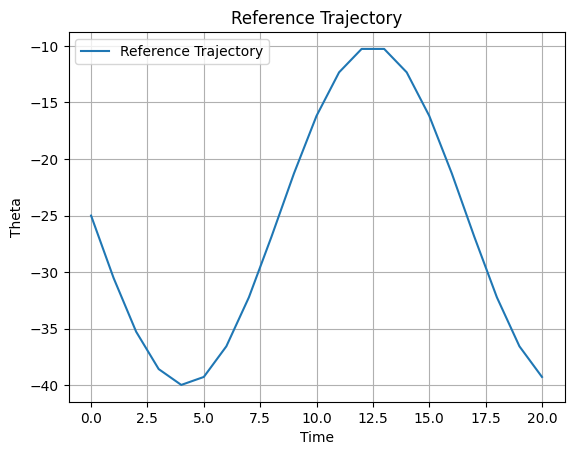

In [117]:
p_vec = np.array([LENGTH, 0.18, 0.0])
A_deg = np.deg2rad(15)      
f_hz = 0.06
offset_deg = np.deg2rad(-25.0)  
phase_deg = 0.0  
time = 20.0          
dt = 1    
Np = 3   
ref = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
# plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [119]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=10.0, w_u=1.0,
                         psi0_rad=np.deg2rad(-20.0), J_min=1e-5,
                         s_steps=10, eps_theta_deg=0.5, sigma_theta_meas_deg=0.5)

[k=0] dψ_max=11.86° | ‖S U_free‖∞=24.95° | ‖S U_tr‖∞=11.86° | Δu0=+3.03 °/s | act(↑,↓)=(0,3)
[k=1] dψ_max=6.91° | ‖S U_free‖∞=19.75° | ‖S U_tr‖∞=6.91° | Δu0=-12.84 °/s | act(↑,↓)=(3,0)
[k=2] dψ_max=8.57° | ‖S U_free‖∞=37.86° | ‖S U_tr‖∞=8.57° | Δu0=+23.88 °/s | act(↑,↓)=(0,3)
[k=3] dψ_max=6.89° | ‖S U_free‖∞=69.21° | ‖S U_tr‖∞=6.89° | Δu0=-36.88 °/s | act(↑,↓)=(3,0)
[k=4] dψ_max=7.84° | ‖S U_free‖∞=57.62° | ‖S U_tr‖∞=6.91° | Δu0=+45.11 °/s | act(↑,↓)=(0,0)
[k=5] dψ_max=6.89° | ‖S U_free‖∞=139.91° | ‖S U_tr‖∞=6.89° | Δu0=-65.85 °/s | act(↑,↓)=(3,0)
[k=6] dψ_max=7.83° | ‖S U_free‖∞=83.07° | ‖S U_tr‖∞=7.83° | Δu0=+69.10 °/s | act(↑,↓)=(1,0)
[k=7] dψ_max=7.67° | ‖S U_free‖∞=157.95° | ‖S U_tr‖∞=7.67° | Δu0=-80.30 °/s | act(↑,↓)=(2,0)
[k=8] dψ_max=11.55° | ‖S U_free‖∞=96.32° | ‖S U_tr‖∞=5.33° | Δu0=+64.24 °/s | act(↑,↓)=(0,0)
[k=9] dψ_max=9.19° | ‖S U_free‖∞=50.06° | ‖S U_tr‖∞=9.19° | Δu0=-29.09 °/s | act(↑,↓)=(2,0)
[k=10] dψ_max=17.63° | ‖S U_free‖∞=25.00° | ‖S U_tr‖∞=1.40° | Δu0=+20.47 °/s

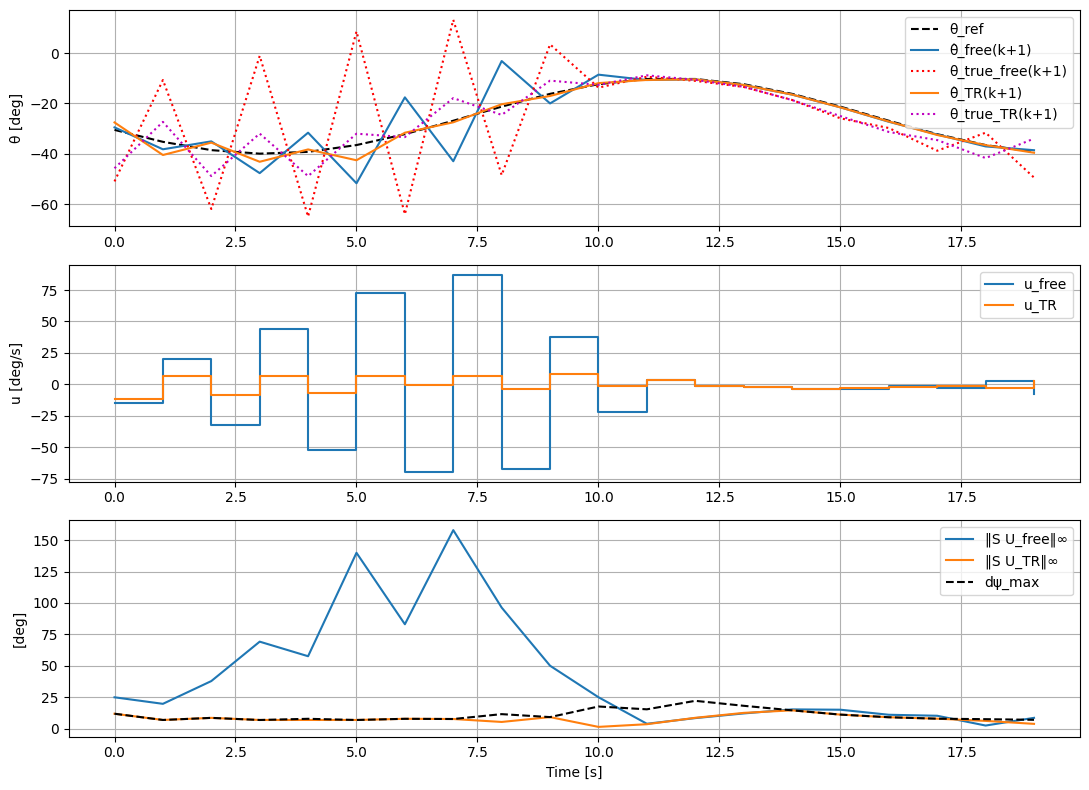

In [121]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()